In [1]:
# Import necessary libraries for text data preprocessing
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import re
import nltk
nltk.data.path.append('/path/to/your/nltk_data')  # adjust this path
from nltk.corpus import stopwords
stopwords.words('english') # Common stopwords

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

from wordcloud import WordCloud
from gensim.models import Word2Vec

from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.utils import pad_sequences
from keras.utils import to_categorical

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Flatten, Dropout, Embedding, GlobalMaxPooling1D, Conv1D, SimpleRNN, LSTM, GRU, Bidirectional


import warnings
warnings.filterwarnings('ignore')


import spacy
nlp = spacy.load('en_core_web_sm')
from tqdm import tqdm
from nltk.corpus import stopwords
# Do#wnloading necessary resources for NLTK
nltk.data.path.append('/your/local/path/to/nltk_data')
from nltk.tokenize import word_tokenize,sent_tokenize# Tokenization tool
#nltk.download('punkt')  # Tokenization tool
#nltk.download('stopwords')  # Common stopwords

# Defining and refining the set of English stopwords
stop_words = set(stopwords.words('english'))
# Removing some stopwords that may carry important sentiment or meaning
stop_words = [i for i in stop_words if i not in ['not','until','against','up', 'down', 'no', 'nor',"aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',
                                                "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 
                                                 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't", "don't"]]



2025-04-16 08:34:52.884765: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744792493.066762      65 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744792493.116977      65 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


1. EXPLORATORY DATA ANALYSIS

1.1  DATA LOADING

In [2]:
# Reading a CSV file containing sentiment data, skipping bad lines
df=pd.read_csv('/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv',encoding='latin',header=None,on_bad_lines='skip')
df.head()
# Renaming columns for better clarity
df.rename(columns={0: 'labels', 5: 'tweets'}, inplace=True)

# Dropping unnecessary columns from the DataFrame
df.drop([1, 2, 3, 4], axis=1, inplace=True)

# Replacing label 4 (positive sentiment) with 1 for uniformity
df['labels'] = df['labels'].replace(4, 1)

# Randomly shuffling the DataFrame and selecting a subset of 10,000 rows
df = df.sample(frac=1)
df = df.head(10000)

# Displaying the first few rows of the DataFrame
df.head()

,labels,tweets
95446,0,"just woke up. it 7.46am, man why did i wake up..."
1057192,1,@PugTales Always enjoy your tweets- you pugs a...
1543207,1,@conradjohnson81 Adam has offically been intro...
414796,0,@baztodd @baztodd I was on round the corner an...
936173,1,@kristinasky I can't wait for the Lost finale!...


1.2  DATA CLEANING

In [3]:
# Function to get the number of words in a tweet
def get_word_len(tweet):
    return len(tweet.split(' '))

# Function to get the number of characters in a tweet
def get_char_len(tweet):
    return len(tweet)

# Function to preprocess a tweet
def preprocess_tweet(tweet):
    # Convert the tweet to lowercase
    tweet = tweet.lower()
    
    # Remove URLs from the tweet
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    
    # Remove mentions (e.g., @username) from the tweet
    tweet = re.sub(r'@\w+', '', tweet)
    
    # Remove special characters and punctuation from the tweet
    tweet = re.sub(r'[^\w\s#]', '', tweet)
    
    # Lemmatize the words using spaCy
    tokens = [token.lemma_ for token in nlp(tweet)]
    
    # Remove stop words
    tokens = [token for token in tokens if token not in stop_words]
    
    # Remove single-character tokens
    tokens = [token for token in tokens if len(token) > 1]
    
    # Join the processed tokens to form the cleaned tweet
    processed_tweet = ' '.join(tokens)
    
    return processed_tweet

# Apply the preprocess_tweet function to each tweet in the dataframe
df['clean_tweets'] = [preprocess_tweet(tw) for tw in tqdm(df['tweets'], position=0, leave=True)]

# Calculate the number of words in each cleaned tweet and store it in a new column
df['tweet_words_length'] = df['clean_tweets'].apply(get_word_len)

# Calculate the number of characters in each cleaned tweet and store it in a new column
df['tweet_chars_length'] = df['clean_tweets'].apply(get_char_len)

# Display the first few rows of the dataframe
df.head()

100%|██████████| 10000/10000 [01:08<00:00, 146.84it/s]


,labels,tweets,clean_tweets,tweet_words_length,tweet_chars_length
95446,0,"just woke up. it 7.46am, man why did i wake up...",wake up 746am man wake up early,7,31
1057192,1,@PugTales Always enjoy your tweets- you pugs a...,always enjoy tweet pug smart maybe even smart ...,11,65
1543207,1,@conradjohnson81 Adam has offically been intro...,adam offically introduce guy fun know em,7,40
414796,0,@baztodd @baztodd I was on round the corner an...,round corner not come see,8,28
936173,1,@kristinasky I can't wait for the Lost finale!...,not wait lose finale arguably good show tv,8,42


1.3   CREATING LABEL DISTRIBUTION

In [4]:
# Count the number of positive and negative tweets in the dataframe
positive_count = df[df['labels'] == 1].shape[0]
negative_count = df[df['labels'] == 0].shape[0]

# Create a pie chart using Plotly Express to visualize the distribution of positive and negative tweets
fig = px.pie(
    values=[positive_count, negative_count],  # Values represent the counts of positive and negative tweets
    title='Distribution of Positive and Negative Tweets',  # Title of the pie chart
    names=['Positive', 'Negative'],  # Labels for the two categories
    hover_name=['Positive', 'Negative'],  # Hover information for each category
    opacity=.9,  # Opacity of the pie chart
    template='simple_white'  # Plotly template for the chart
)

# Display the pie chart
fig.show()

1.4  CREATING WORD CLOUD

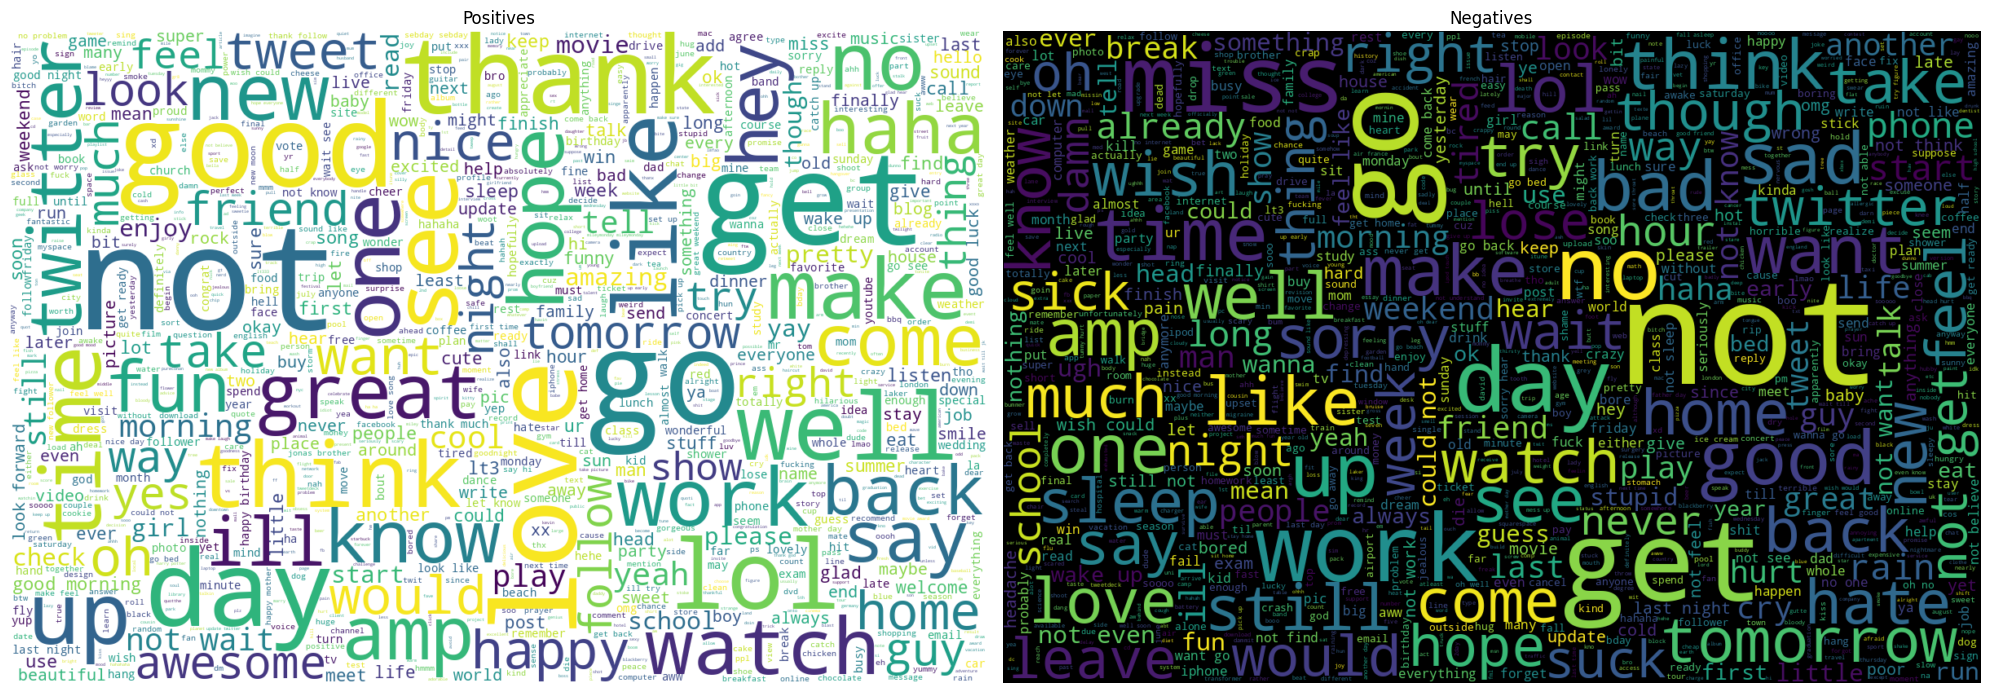

In [5]:
# Set up a figure with a specified size
plt.figure(figsize=(20, 8))

# Define stopwords for WordCloud (common words to exclude)
STOPWORDS = ['im','today','really','need','tonight']

# Plot two subplots side by side
plt.subplot(1, 2, 1)

# Generate and display a WordCloud for positive tweets
wordcloud_1 = WordCloud(
    width=1200, height=800, max_words=1000, contour_width=2,
    background_color='white', stopwords=STOPWORDS, max_font_size=180,
    colormap='viridis'
).generate(' '.join(df[df['labels'] == 1]['clean_tweets']))

plt.imshow(wordcloud_1, interpolation='bilinear')
plt.axis('off')
plt.title('Positives')

# Plot the second subplot
plt.subplot(1, 2, 2)

# Generate and display a WordCloud for negative tweets
wordcloud_2 = WordCloud(
    width=1200, height=800, max_words=1000, contour_width=2,
    background_color='black', stopwords=STOPWORDS, max_font_size=180,
    colormap='viridis'
).generate(' '.join(df[df['labels'] == 0]['clean_tweets']))

plt.imshow(wordcloud_2, interpolation='bilinear')
plt.axis('off')
plt.title('Negatives')

# Turn off axis for the entire plot
plt.axis('off')

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()

1.5  CREATING WORD LENGTH DISTRIBUTION

In [6]:
# Create distribution plots for word count and character count for positive and negative tweets
fig_words = ff.create_distplot(
    [df[df['labels'] == 1]['tweet_words_length'], df[df['labels'] == 0]['tweet_words_length']],
    ['Positive', 'Negative'],
    bin_size=25,
    show_hist=False,
    show_rug=False
)

fig_chars = ff.create_distplot(
    [df[df['labels'] == 1]['tweet_chars_length'], df[df['labels'] == 0]['tweet_chars_length']],
    ['Positive', 'Negative'],
    bin_size=25,
    show_hist=False,
    show_rug=False
)

# Set titles and labels for the distribution plots
fig_chars.update_layout(title="Distribution Plot on Character Count", xaxis_title="Number of Characters", yaxis_title="Frequency")
fig_words.update_layout(title="Distribution Plot on Word Count", xaxis_title="Number of Words", yaxis_title="Frequency")

# Combine the plots in a 2-column layout
fig = make_subplots(rows=1, cols=2, subplot_titles=["Word Count", "Character Count"])
fig.add_trace(fig_words['data'][0], row=1, col=1)
fig.add_trace(fig_words['data'][1], row=1, col=1)
fig.add_trace(fig_chars['data'][0], row=1, col=2)
fig.add_trace(fig_chars['data'][1], row=1, col=2)

# Update overall layout and show the plot
fig.update_layout(title_text="Distribution Plots - Word Count vs Character Count", showlegend=True, font=dict(family="Arial", size=15, color="black"))
fig.show()

2) Data Preparation for Model Building

2.1) Loading the Dataset

In [7]:
df = pd.read_csv('/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv', encoding = "latin", header = None, on_bad_lines='skip')

df.rename(columns={0: 'labels', 5: 'tweets'}, inplace=True)
df.drop([1,2,3,4], axis=1, inplace = True)

df['labels'] = df['labels'].replace(4,1)

df = df.sample(frac=1)
df = df.head(10000)

2.2) Data Cleaning

In [8]:
df['clean_tweets'] = [preprocess_tweet(tw) for tw in tqdm(df['tweets'] ,position=0, leave=True )]
df['tweet_words_length'] = df['clean_tweets'].apply(get_word_len)
df['tweet_chars_length'] = df['clean_tweets'].apply(get_char_len)

df.head()

100%|██████████| 10000/10000 [01:06<00:00, 149.60it/s]


,labels,tweets,clean_tweets,tweet_words_length,tweet_chars_length
547794,0,I think Guitar Hero has lost a lot of its magi...,think guitar hero lose lot magic not feel spec...,10,57
916916,1,Having fries plus greentea. Mmm - http://twee...,fry plus greentea mmm,7,24
170282,0,The new tecas driver license design is ugly,new tecas driver license design ugly,6,36
1281586,1,@natalietran You will an amazing time! It was ...,amazing time incredible,3,23
155223,0,Do i really look sad? Everyone says i look sad.,really look sad everyone say look sad,7,37


3) Trying different Neural Networks

3.1) Splitting Dataset into Training/Testing and Validation

In [9]:
# Splitting the dataset into training and testing sets with an 80-20 split
x_train, x_test, y_train, y_test = train_test_split(df['clean_tweets'], df['labels'], test_size=0.2, random_state=42)

# Further splitting the test set into validation and final test sets with a 50-50 split
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5)

# Creating a pie chart to visualize the distribution of tweet counts in training, testing, and validation sets
fig = px.pie(values=[len(x_train), len(x_test), len(x_val)], title='Distribution of Training, Testing, and Validation Tweets', 
             names=['Training', 'Testing', 'Validation'], hover_name=['Training', 'Testing', 'Validation'], opacity=0.9, template='simple_white')

# Displaying the pie chart
fig.show()

3.2) One Hot Encoded + Model Training

In [10]:
# Setting up parameters for neural network training
epochs_ = 10            # Number of training epochs
seq_len = 20            # Length of input sequences
batch_size_ = 64        # Batch size for training
training_size = .8      # Percentage of data used for training
embedding_len = 100     # Length of word embeddings

# Using CountVectorizer with binary encoding for tweets
vec = CountVectorizer(binary=True)
vec = vec.fit(df['clean_tweets'])

# Transforming and converting tweets into arrays
enc_tweets = vec.transform(df['clean_tweets']).toarray()

# Splitting the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(enc_tweets, df['labels'], test_size=training_size, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5)

# Building a neural network model with multiple dense layers and dropout for regularization
model = Sequential()
model.add(Dense(2048, activation='relu', input_shape=(enc_tweets.shape[1],)))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compiling the model using binary crossentropy loss and Adam optimizer with a specified learning rate
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# Training the model and storing the training history
history_1 = model.fit(x_train, y_train, epochs=epochs_, batch_size=batch_size_, validation_data=(x_val, y_val))

# Evaluating and printing the model's accuracy on the testing data
print('\n')
print("Model Evaluation on Testing Data: ", round(model.evaluate(x_test, y_test)[1] * 100, 2))

2025-04-16 08:37:58.588223: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 425ms/step - accuracy: 0.5425 - loss: 0.6930 - val_accuracy: 0.5390 - val_loss: 0.6918
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 390ms/step - accuracy: 0.5333 - loss: 0.6906 - val_accuracy: 0.5562 - val_loss: 0.6892
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 382ms/step - accuracy: 0.5848 - loss: 0.6822 - val_accuracy: 0.6037 - val_loss: 0.6821
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 397ms/step - accuracy: 0.6432 - loss: 0.6692 - val_accuracy: 0.6463 - val_loss: 0.6667
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 381ms/step - accuracy: 0.7313 - loss: 0.6325 - val_accuracy: 0.6898 - val_loss: 0.6371
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 396ms/step - accuracy: 0.8026 - loss: 0.5564 - val_accuracy: 0.7025 - val_loss: 0.5971
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 382ms/step - accuracy: 0.8710 - loss: 0.4444 - val_accuracy: 0.7080 - val_loss: 0.5749
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 396ms/step - accuracy: 0.9234 - loss: 0.3050 - val_accu

3.3) Count Vectorizer + Model Training

In [11]:
# Using CountVectorizer without binary encoding for tweets
vec = CountVectorizer(binary=False)
vec = vec.fit(df['clean_tweets'])

# Transforming and converting tweets into arrays
enc_tweets = vec.transform(df['clean_tweets']).toarray()

# Splitting the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(enc_tweets, df['labels'], test_size=training_size, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5)

# Building a neural network model with multiple dense layers and dropout for regularization
model = Sequential()
model.add(Dense(2048, activation='relu', input_shape=(enc_tweets.shape[1],)))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compiling the model using binary crossentropy loss and Adam optimizer with a specified learning rate
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# Training the model and storing the training history
history_2 = model.fit(x_train, y_train, epochs=epochs_, batch_size=batch_size_, validation_data=(x_val, y_val))

# Evaluating and printing the model's accuracy on the testing data
print('\n')
print("Model Evaluation on Testing Data: ", round(model.evaluate(x_test, y_test)[1] * 100, 2))

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 405ms/step - accuracy: 0.5170 - loss: 0.6936 - val_accuracy: 0.5602 - val_loss: 0.6915
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 394ms/step - accuracy: 0.5416 - loss: 0.6903 - val_accuracy: 0.6225 - val_loss: 0.6886
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 380ms/step - accuracy: 0.6196 - loss: 0.6818 - val_accuracy: 0.6718 - val_loss: 0.6780
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 393ms/step - accuracy: 0.6917 - loss: 0.6588 - val_accuracy: 0.6875 - val_loss: 0.6549
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 381ms/step - accuracy: 0.7487 - loss: 0.6120 - val_accuracy: 0.7000 - val_loss: 0.6215
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 382ms/step - accuracy: 0.8504 - loss: 0.5059 - val_accuracy: 0.7072 - val_loss: 0.5847
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 397ms/step - accuracy: 0.8866 - loss: 0.3901 - val_accuracy: 0.7078 - val_loss: 0.5870
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 381ms/step - accuracy: 0.9411 - loss: 0.2552 - val_accu

3.4) TF-IDF + Model Training

In [12]:
# Using TF-IDF vectorization for tweets
tfidf = TfidfVectorizer()
enc_tweets = tfidf.fit_transform(df['clean_tweets']).toarray()

# Splitting the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(enc_tweets, df['labels'], test_size=training_size, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5)

# Building a neural network model with multiple dense layers and dropout for regularization
model = Sequential()
model.add(Dense(2048, activation='relu', input_shape=(enc_tweets.shape[1],)))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compiling the model using binary crossentropy loss and Adam optimizer with a specified learning rate
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# Training the model and storing the training history
history_3 = model.fit(x_train, y_train, epochs=epochs_, batch_size=batch_size_, validation_data=(x_val, y_val))

# Evaluating and printing the model's accuracy on the testing data
print('\n')
print("Model Evaluation on Testing Data: ", round(model.evaluate(x_test, y_test)[1] * 100, 2))

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.4972 - loss: 0.6933 - val_accuracy: 0.5380 - val_loss: 0.6925
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 428ms/step - accuracy: 0.5314 - loss: 0.6921 - val_accuracy: 0.6208 - val_loss: 0.6913
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 402ms/step - accuracy: 0.6030 - loss: 0.6876 - val_accuracy: 0.5825 - val_loss: 0.6880
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 416ms/step - accuracy: 0.6397 - loss: 0.6804 - val_accuracy: 0.6712 - val_loss: 0.6787
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 400ms/step - accuracy: 0.7591 - loss: 0.6504 - val_accuracy: 0.6900 - val_loss: 0.6545
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 406ms/step - accuracy: 0.8343 - loss: 0.5811 - val_accuracy: 0.7057 - val_loss: 0.6071
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 409ms/step - accuracy: 0.9186 - loss: 0.4366 - val_accuracy: 0.7007 - val_loss: 0.5724
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 404ms/step - accuracy: 0.9404 - loss: 0.2709 - val_accurac

3.5) ANN with Text Sequencess

3.5.1) Loading the Dataset

In [13]:
# Setting up parameters for neural network training
epochs_ = 10            # Number of training epochs
seq_len = 20            # Length of input sequences
batch_size_ = 64        # Batch size for training
training_size = .8      # Percentage of data used for training
embedding_len = 100     # Length of word embeddings

# Loading and preprocessing the Sentiment140 dataset
df = pd.read_csv('/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv', encoding="latin", header=None, on_bad_lines='skip')
df.rename(columns={0: 'labels', 5: 'tweets'}, inplace=True)
df.drop([1, 2, 3, 4], axis=1, inplace=True)

# Converting labels to binary format (0 or 1)
df['labels'] = df['labels'].replace(4, 1)

# Shuffling and limiting the dataset size to 20,000 samples
df = df.sample(frac=1)
df = df.head(20000)

3.5.2) Cleaning the Dataset

In [14]:
# Adding a new column 'clean_tweets' by applying a tweet preprocessing function to each tweet in the dataset
df['clean_tweets'] = [preprocess_tweet(tw) for tw in tqdm(df['tweets'], position=0, leave=True)]

# Adding a new column 'tweet_words_length' by applying a function to get the word length of each cleaned tweet
df['tweet_words_length'] = df['clean_tweets'].apply(get_word_len)

# Adding a new column 'tweet_chars_length' by applying a function to get the character length of each cleaned tweet
df['tweet_chars_length'] = df['clean_tweets'].apply(get_char_len)

100%|██████████| 20000/20000 [02:13<00:00, 149.90it/s]


3.5.3) Text Encoding

In [15]:
# Initializing a Tokenizer and fitting it on the preprocessed cleaned tweets
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['clean_tweets'])

# Creating word index and index word mappings for reference
word_index = tokenizer.word_index
index_word = tokenizer.index_word

# Converting the cleaned tweets to sequences of integers using the Tokenizer
sequences = tokenizer.texts_to_sequences(df['clean_tweets'])
enc_tweets = pad_sequences(sequences, maxlen=seq_len, padding='post')

# Splitting the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(enc_tweets, df['labels'], test_size=training_size, random_state=42)

# Further splitting the testing set into validation and test sets
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5)

3.5.4) Training the Model

In [16]:
# Creating a sequential model with dense layers for a binary classification task
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(seq_len,)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compiling the model with binary crossentropy loss, Adam optimizer, and accuracy metric
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# Training the model on the training data and validating on the validation data
history_4 = model.fit(x_train, y_train, epochs=epochs_, batch_size=batch_size_, validation_data=(x_val, y_val))

# Evaluating and printing the accuracy on the testing data
print('\n')
print("Model Evaluation on Testing Data:", round(model.evaluate(x_test, y_test)[1] * 100, 2))

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4997 - loss: 188.4603 - val_accuracy: 0.5034 - val_loss: 137.1702
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4928 - loss: 133.0170 - val_accuracy: 0.5069 - val_loss: 106.0407
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4944 - loss: 113.1938 - val_accuracy: 0.5054 - val_loss: 87.1449
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4854 - loss: 87.7065 - val_accuracy: 0.5039 - val_loss: 76.6577
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4936 - loss: 75.9594 - val_accuracy: 0.5036 - val_loss: 69.1393
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4913 - loss: 69.3339 - val_accuracy: 0.4985 - val_loss: 63.6193
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4975 - loss: 63.7775 - val_accuracy: 0.4986 - val_loss: 59.7094
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5024 - loss: 52.4546 - val_accuracy

3.6) ANN + Embedding with Text Sequencess

In [17]:
# Create a sequential model
model = Sequential()

# Add an embedding layer with specified input dimensions, output dimensions, and input length
model.add(Embedding(input_dim=len(word_index) + 1, output_dim=embedding_len, input_length=seq_len))

# Flatten the 3D output to 2D for further processing
model.add(Flatten())

# Add a densely connected layer with 64 neurons and ReLU activation function
model.add(Dense(64, activation='relu'))

# Add another densely connected layer with 32 neurons and ReLU activation function
model.add(Dense(32, activation='relu'))

# Add a final densely connected layer with 1 neuron and sigmoid activation function for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model with binary cross-entropy loss, Adam optimizer, and accuracy as the metric
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# Train the model on training data, validate on validation data, and store training history
history_5 = model.fit(x_train, y_train, epochs=epochs_, batch_size=batch_size_, validation_data=(x_val, y_val))
print('\n')
# Evaluate the model on testing data and print the accuracy
print("Model Evaluation on Testing Data: ", round(model.evaluate(x_test, y_test)[1] * 100, 2))

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5146 - loss: 0.6926 - val_accuracy: 0.5189 - val_loss: 0.6909
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5665 - loss: 0.6870 - val_accuracy: 0.5639 - val_loss: 0.6875
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6125 - loss: 0.6795 - val_accuracy: 0.5756 - val_loss: 0.6807
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6797 - loss: 0.6611 - val_accuracy: 0.6234 - val_loss: 0.6667
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7530 - loss: 0.6234 - val_accuracy: 0.6304 - val_loss: 0.6458
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8220 - loss: 0.5598 - val_accuracy: 0.6837 - val_loss: 0.6155
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8659 - loss: 0.4822 - val_accuracy: 0.6889 - val_loss: 0.5938
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8847 - loss: 0.4012 - val_accuracy: 0.6915 - v

3.7) RNN + Embedding with Text Sequences

In [19]:
from tensorflow.keras.layers import SimpleRNN
model = Sequential()

model.add(Embedding(input_dim = len(word_index) + 1, output_dim = embedding_len, input_length = seq_len))
model.add(SimpleRNN(units=100,dropout=0.2,return_sequences = True))
model.add(SimpleRNN(units=100))
model.add(Dense(32, activation='relu'))
model.add(Dropout())
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer = Adam(learning_rate = 0.0001), metrics=['accuracy'])

history_6 = model.fit(x_train, y_train, epochs = epochs_, batch_size = batch_size_, validation_data=(x_val, y_val))
print('\n')
print("Model Evaluation on Testing Data : ", round(model.evaluate(x_test,y_test)[1]*100,2))

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.4951 - loss: 0.7139 - val_accuracy: 0.5293 - val_loss: 0.6919
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.5516 - loss: 0.6846 - val_accuracy: 0.5319 - val_loss: 0.6900
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.5655 - loss: 0.6770 - val_accuracy: 0.5524 - val_loss: 0.6837
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.6165 - loss: 0.6511 - val_accuracy: 0.5885 - val_loss: 0.6709
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.6747 - loss: 0.6121 - val_accuracy: 0.6250 - val_loss: 0.6521
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.7663 - loss: 0.5141 - val_accuracy: 0.6484 - val_loss: 0.6561
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.8082 - loss: 0.4461 - val_accuracy: 0.6536 - val_loss: 0.6924
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.8682 - loss: 0.3542 - val_accuracy: 0.6472 - v

3.7) LSTM + Embedding with Text Sequences

In [25]:
# Create a Sequential model
model = Sequential()

# Add an Embedding layer with input dimensions, output dimensions, and input length
model.add(Embedding(input_dim=len(word_index) + 1, output_dim=embedding_len, input_length=seq_len))

# Add an LSTM layer with 128 units, dropout of 0.2, and return sequences for the next layer
model.add(LSTM(units=128, dropout=0.2, return_sequences=True))

# Add another LSTM layer with 64 units
model.add(LSTM(64))

# Add a Dense layer with 64 units and ReLU activation function
model.add(Dense(64, activation='relu'))

# Add a Dropout layer with dropout rate of 0.5
model.add(Dropout(0.5))

# Add a Dense layer with 1 unit and sigmoid activation function for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model with binary crossentropy loss, Adam optimizer with learning rate of 0.0001, and accuracy metric
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# Train the model on training data and validate on validation data
history_7 = model.fit(x_train, y_train, epochs=epochs_, batch_size=batch_size_, validation_data=(x_val, y_val))

# Print a newline for better readability
print('\n')

# Evaluate and print the model accuracy on testing data
print("Model Evaluation on Testing Data:", round(model.evaluate(x_test, y_test)[1] * 100, 2))

# Save the model to a file
model.save('Embedding_LSTM.h5')

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 84ms/step - accuracy: 0.4906 - loss: 0.6930 - val_accuracy: 0.5050 - val_loss: 0.6928
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.5035 - loss: 0.6930 - val_accuracy: 0.5069 - val_loss: 0.6925
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.5243 - loss: 0.6919 - val_accuracy: 0.5393 - val_loss: 0.6901
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.5647 - loss: 0.6859 - val_accuracy: 0.6708 - val_loss: 0.6218
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.7452 - loss: 0.5455 - val_accuracy: 0.6810 - val_loss: 0.6151
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.8128 - loss: 0.4504 - val_accuracy: 0.7029 - val_loss: 0.5875
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.8538 - loss: 0.3741 - val_accuracy: 0.6999 - val_loss: 0.6139
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - accuracy: 0.8816 - loss: 0.3160 - val_accuracy: 0.6950 - 

3.8) GRU + Embedding with Text Sequences

In [26]:
# Define a Sequential model
model = Sequential()
# Add an Embedding layer to the model
# input_dim: Vocabulary size (length of word_index + 1)
# output_dim: Dimension of the dense embedding
# input_length: Length of input sequences
model.add(Embedding(input_dim=len(word_index) + 1, output_dim=embedding_len, input_length=seq_len))
# Add a GRU layer with 128 units and dropout for sequence data
model.add(GRU(128, dropout=0.2, return_sequences=True))
# Add another GRU layer with 64 units
model.add(GRU(64))
# Add a Dense layer with 64 units and ReLU activation function
model.add(Dense(64, activation='relu'))
# Add a Dropout layer with a dropout rate of 0.5
model.add(Dropout(0.5))
# Add the output layer with 1 unit and a sigmoid activation function for binary classification
model.add(Dense(1, activation='sigmoid'))
# Compile the model with binary crossentropy loss, Adam optimizer, and accuracy metric
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
# Train the model on training data, validate on validation data
history_7 = model.fit(x_train, y_train, epochs=epochs_, batch_size=batch_size_, validation_data=(x_val, y_val))
# Evaluate and print the accuracy on testing data
print('\n')
print("Model Evaluation on Testing Data : ", round(model.evaluate(x_test, y_test)[1] * 100, 2))

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 81ms/step - accuracy: 0.5088 - loss: 0.6931 - val_accuracy: 0.5024 - val_loss: 0.6931
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.5008 - loss: 0.6932 - val_accuracy: 0.5023 - val_loss: 0.6931
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.5138 - loss: 0.6930 - val_accuracy: 0.5025 - val_loss: 0.6931
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.5171 - loss: 0.6927 - val_accuracy: 0.5023 - val_loss: 0.6931
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - accuracy: 0.5100 - loss: 0.6928 - val_accuracy: 0.5020 - val_loss: 0.6931
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.5209 - loss: 0.6922 - val_accuracy: 0.5169 - val_loss: 0.6930
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.4986 - loss: 0.6933 - val_accuracy: 0.4980 - val_loss: 0.6930
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.5144 - loss: 0.6930 - val_accuracy: 0.5090 - 